# 1 - Multiclass classification

## 1.1 - Dataset

There are 5000 training examples in ex3data1.mat, where each training
example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at
that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional
vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training
example for a handwritten digit image.

In [1]:
%plot -f svg -w 1000
% Load saved matrices from file
addpath('includes/ex3')
load('ex3data1.mat');

%% Setup the parameters you will use for this part of the exercise
input_layer_size  = 400;  % 20x20 Input Images of Digits
num_labels = 10;          % 10 labels, from 1 to 10
                          % (note that we have mapped "0" to label 10)
m = size(X, 1);

## 1.2 - Visualizing the data


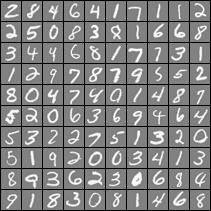

In [2]:
rand_indices = randperm(m);
sel = X(rand_indices(1:100), :);

displayData(sel);

## 1.3 - Vectorizing Logistic Regression
### 1.3.1 - Vectorizing the cost function

In [3]:
function [J, grad] = lrCostFunction(theta, X, y, lambda)
    m = length(y);

    hypothesis = sigmoid(X*theta);
    J = 1/m * sum(-y.*log(hypothesis) - (1-y).*log(1-hypothesis));
endfunction

### 1.3.2 - Vectorizing the gradient

We can complete our cost function with our gradient calculation.

In [4]:
function [J, grad] = lrCostFunction(theta, X, y, lambda)
    m = length(y);

    hypothesis = sigmoid(X*theta);
    J = 1/m * sum(-y.*log(hypothesis) - (1-y).*log(1-hypothesis));
    
    grad = 1/m * X'*(hypothesis-y);
endfunction

### 1.3.3 - Vectorizing regularization

In [5]:
function [J, grad] = lrCostFunction(theta, X, y, lambda)
    m = length(y);

    hypothesis = sigmoid(X*theta);
    J = 1/m * sum(-y.*log(hypothesis) - (1-y).*log(1-hypothesis))+ lambda/(2*m) * sum(theta(2:length(theta)).^2);
    
    grad = 1/m * X'*(hypothesis-y);
    grad(2:end) = grad(2:end) + lambda * theta(2:end) ./ m;
endfunction

In [6]:
fprintf('Testing lrCostFunction() with regularization');

theta_t = [-2; -1; 1; 2];
X_t = [ones(5,1) reshape(1:15,5,3)/10];
y_t = ([1;0;1;0;1] >= 0.5);
lambda_t = 3;
[J grad] = lrCostFunction(theta_t, X_t, y_t, lambda_t);

fprintf('\nCost: %f\n', J);
fprintf('Expected cost: 2.534819\n');
fprintf('Gradients:\n');
fprintf(' %f \n', grad);
fprintf('Expected gradients:\n');
fprintf(' 0.146561\n -0.548558\n 0.724722\n 1.398003\n');

Testing lrCostFunction() with regularization

Cost: 2.534819
Expected cost: 2.534819
Gradients:
 0.146561 
 -0.548558 
 0.724722 
 1.398003 
Expected gradients:
 0.146561
 -0.548558
 0.724722
 1.398003
Testing lrCostFunction() with regularization


## 1.4 - One-vs-all classification



In [7]:
function [all_theta] = oneVsAll(X, y, num_labels, lambda)
    m = size(X, 1);
    n = size(X, 2);
    all_theta = zeros(num_labels, n+1);
    X = [ones(m, 1) X];

    for c = 1:num_labels
        % Set Initial theta
        initial_theta = zeros(n + 1, 1);

        % Set options for fminunc
        options = optimset('GradObj', 'on', 'MaxIter', 50);
        % 
        % Run fmincg to obtain the optimal theta
        % This function will return theta and the cost 
        [theta] = ...
            fmincg (@(t)(lrCostFunction(t, X, (y == c), lambda)), ...
                initial_theta, options);

        %disp(size(theta')), disp(size(all_theta))
        all_theta(c, :) = theta';
    end
endfunction

In [8]:
%%time
fprintf('\nTraining One-vs-All Logistic Regression...\n')

lambda = 0.1;
[all_theta] = oneVsAll(X, y, num_labels, lambda);


Training One-vs-All Logistic Regression...
Iteration    50 | Cost: 1.394837e-02
Iteration    50 | Cost: 5.725265e-02
Iteration    50 | Cost: 6.378830e-02
Iteration    50 | Cost: 3.584974e-02
Iteration    50 | Cost: 6.187496e-02
Iteration    50 | Cost: 2.223260e-02
Iteration    50 | Cost: 3.553032e-02
Iteration    50 | Cost: 8.543501e-02
Iteration    50 | Cost: 8.073296e-02
Iteration    50 | Cost: 9.523453e-03
Time: 53.4531888962 seconds.



### 1.4.1 - Prediction

In [9]:
function p = predictOneVsAll(all_theta, X)
    m = size(X, 1);
    num_labels = size(all_theta, 1);

    p = zeros(size(X, 1), 1);

    % Add ones to the X data matrix
    X = [ones(m, 1) X];

    ova = X*all_theta';
    [m, p] = max(ova, [], 2);
endfunction

In [10]:
pred = predictOneVsAll(all_theta, X);

fprintf('\nTraining Set Accuracy: %f\n', mean(double(pred == y)) * 100);


Training Set Accuracy: 95.000000


# 2 - Neural Networks

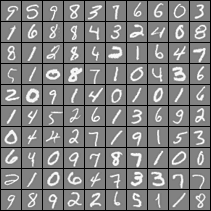

In [11]:
clear ; close all; clc

%% Setup the parameters you will use for this exercise
input_layer_size  = 400;  % 20x20 Input Images of Digits
hidden_layer_size = 25;   % 25 hidden units
num_labels = 10;          % 10 labels, from 1 to 10  

load('ex3data1.mat');
m = size(X, 1);

% Randomly select 100 data points to display
sel = randperm(size(X, 1));
sel = sel(1:100);

displayData(X(sel, :));

## 2.1 - Model representation

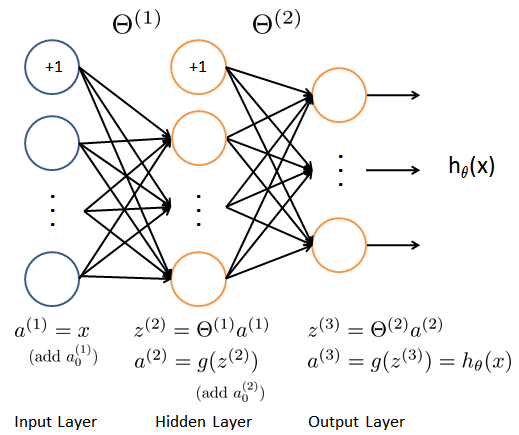

In [12]:
% Load saved matrices from file
load('ex3weights.mat');

% Theta1 has size 25 x 401
% Theta2 has size 10 x 26

% pkg load image;
% workaround for octave_kernel.
imshow(im2double(imread('includes/ex3/neural-net-structure.png')));

## 2.2 - Feedforward propagation and prediction

In [13]:
function p = predict(Theta1, Theta2, X)
    m = size(X, 1);
    num_labels = size(Theta2, 1);

    X = [ones(m, 1), X];

    A1 = X';
    A2 = [ones(1, m); sigmoid(Theta1*A1)];
    A3 = sigmoid(Theta2*A2);
    
    [m, predictions] = max(A3, [], 1);
    p = predictions';
endfunction

In [14]:
pred = predict(Theta1, Theta2, X);

fprintf('\nTraining Set Accuracy: %f\n', mean(double(pred == y)) * 100);


Training Set Accuracy: 97.520000


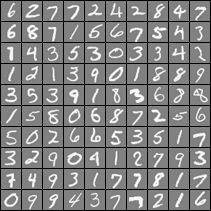

In [15]:
rp = randperm(m);
displayData(X(rp(1:100), :));

In [16]:
reshape(...
    mod(...
        predict(Theta1, Theta2, X(rp(1:100), :))...
    , 10)...
, 10, 10)'

ans =

   6   2   7   7   2   4   2   8   4   7
   6   8   7   1   5   6   7   5   4   3
   1   4   3   5   3   0   3   3   4   2
   1   2   1   3   9   0   1   8   8   9
   3   5   3   9   1   8   3   6   8   8
   1   5   8   0   6   8   7   2   5   6
   5   0   2   6   6   5   3   5   1   7
   3   2   9   0   4   1   8   7   9   3
   7   4   9   3   1   7   7   8   1   7
   0   9   9   4   3   7   7   2   1   6

